# **CVPS20 // Final**

assigned : **Dec 3, 2020**

DUE : **Dec 8, 2020 11:59pm**

## Assessing Traffic Flow with Highway Transportation Video

---

In this notebook you will use highway traffic camera video to assess traffic flow by first detecting vehicles and then merging those detections together into trajectories.  This is both a classic computer vision problem and a real-world application of object tracking that has tremendous societal benefit for determining the safety of roads, usage patterns, maintainence impacts, and routing of emergency vehicles during times of high congestion.

*NOTE: this final is not timed, but it is designed to take roughly 5 hr to complete.  That said, I <u>strongly</u> suggest that you give yourself plenty of time and do not wait until a few hours before the deadline to begin.*

<b>

<u>*PLEASE MAKE A COPY OF THIS NOTEBOOK AND THEN SHARE THAT WITH ME.*</u>

Rules for the midterm:

1. You may <u>not</u> work with anyone else on this midterm.  Doing so will result in a violation of the *University of Delaware*'s Academic Code of Conduct (see [syllabus](https://cvps20.slack.com/#syllabus)).  Direct copying from someone else's notebook is also not permitted.

2. You <u>may</u> use any other resource available to you including class notebooks, homework solution notebooks, slides, videos, stackoverflow, *etc*.

3. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

4. If you are taking this course for credit, please sign up for a 20 minute presentation time slot on the [calendar](https://docs.google.com/spreadsheets/d/1YUH0ddHC3rYp_ufmeIhcIozGmqqSf_6IzFw9h77Ox4E/edit#gid=0).

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**By adding your name to the box below you declare that the work in this final was done by you, that you did not work with anyone else (either a student in this class or otherwise), that you did not share your solutions with anyone, and that you did not receive solutions from anyone.**

Ming Lian

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Before you begin, make sure that the Runtime of this notebook is using a GPU accelerator.**

In the folder `final/data/` within `cvps20/` you will find three files:

1. `highway_traffic.mp4` – the traffic camera video (grabbed from [here](https://www.youtube.com/watch?v=KBsqQez-O4w))

2. `traffic_label_pos_right.npy` – a `numpy` array containing locations of vehicles in a given frame

3. `traffic_label_neg_right.npy` – a `numpy` array containing locations without vehicles in a given frame

*Note: the locations and frame numbers apply to the video when it is read in as indicated below.*

**Read in every fourth row and column of every fourth frame of the traffic camera video into a `numpy` array.$^{\dagger}$**

<small> $^{\dagger}$ This should result in an array of shape $(1360, 306, 554, 3)$ </small>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage.measurements as snm 
#from matplotlib import animation
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter, uniform_filter1d
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening
import scipy.ndimage.measurements as snm
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [ ]:
fname =  '/content/drive/MyDrive/cvps20/final/data/highway_traffic.mp4'
cap = cv2.VideoCapture(fname)

In [ ]:
# -- get capture params
nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
nrow = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ncol = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

print("video is : ({0}, {1}, {2})".format(nfr, nrow, ncol))

video is : (5437, 1222, 2214)


In [ ]:
imgs = []

for ii in range(nfr):

  if (ii%4) == 0:
    imgs.append(cap.read()[1][::4, ::4, ::-1]/255)
  else:
    cap.read()

In [ ]:
imgs = np.array(imgs)
imgs.shape

(1360, 306, 554, 3)

You will be concentrating exclusively on the vehicles in the right four lanes (the ones traveling away from the camera).  **Count the total number of vehicles that travel through each of those four lanes throughout the video.$^{\dagger}$**

<small> $^{\dagger}$ Using `python` code (i.e., not by hand), but note that this does not necessarily require any object detection or tracking yet. </small>

In [ ]:
#The background of the environment

BackGround = imgs.mean(axis=0)

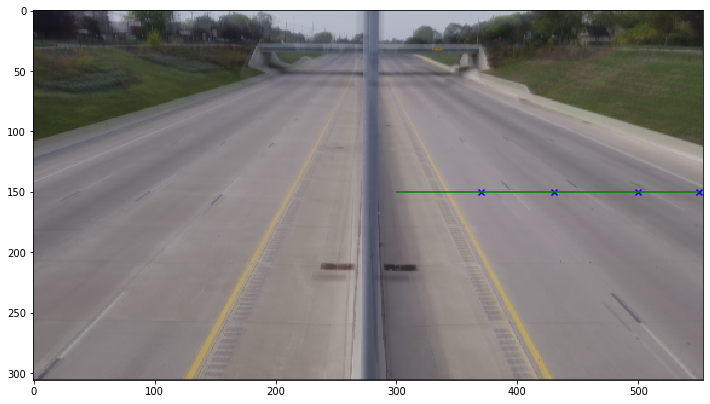

In [ ]:
#Plot the background and choose the points for the counting. 

fig, ax = plt.subplots()

ax.imshow(BackGround)
ax.hlines(150, 300, 550, 'g')
ax.scatter([370,430, 500, 550], [150, 150, 150, 150], c='b', marker='x')

* Counting are done on the blue crosses marked in the figure above. The coordinates are (370, 150), (430, 150), (500, 150), (550, 150).

In [ ]:
imgsLum = imgs.mean(axis=-1)
BackGroundLum = BackGround.mean(axis=-1)

CountLane1 = imgsLum[:, 150, 370] - BackGroundLum[150,370]
CountLane2 = imgsLum[:, 150, 430] - BackGroundLum[150,430]
CountLane3 = imgsLum[:, 150, 500] - BackGroundLum[150,500]
CountLane4 = imgsLum[:, 150, 550] - BackGroundLum[150,550]

CountLane = np.stack((CountLane1, CountLane2, CountLane3, CountLane4))

del CountLane1, CountLane2, CountLane3, CountLane4

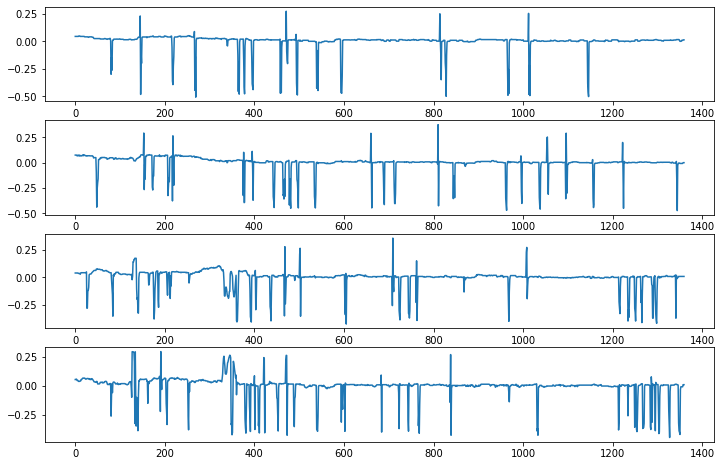

In [ ]:
fig, ax = plt.subplots(4,1)

for ii in range(4):
  ax[ii].plot(CountLane[ii])

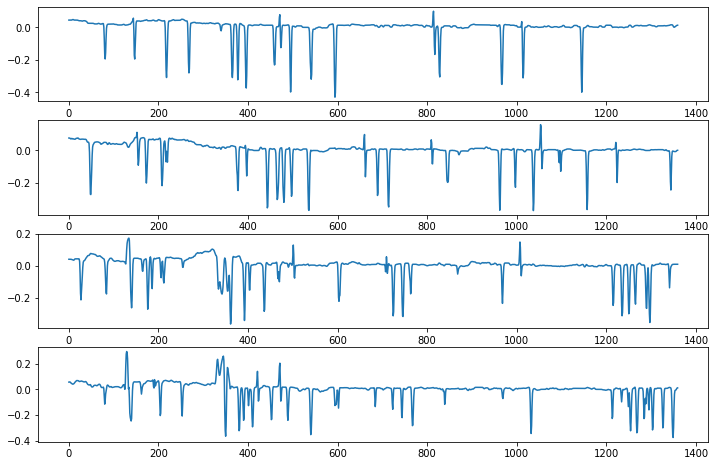

In [ ]:
 #Smooth the curves with 1d Gaussian filter

fig, ax = plt.subplots(4,1)

for ii in range(4):
  ax[ii].plot(gaussian_filter1d(CountLane[ii], 1))

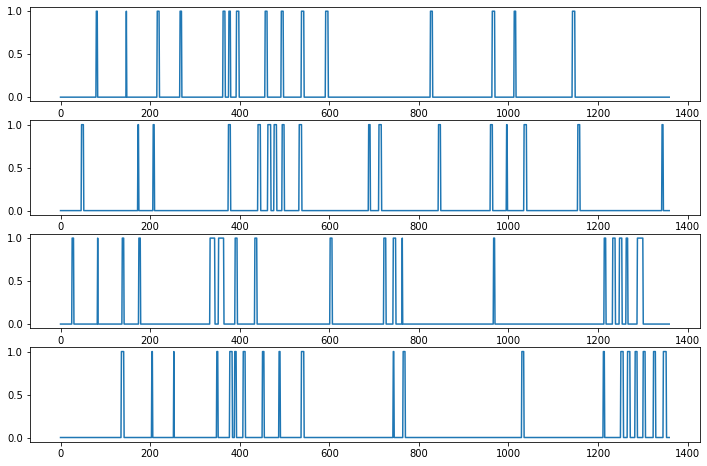

In [ ]:
fig, ax = plt.subplots(4,1)

for ii in range(4):
  ax[ii].plot(gaussian_filter1d(CountLane[ii], 2) < -0.1)

In [ ]:
CountResult = []

for ii in range(4):
  a, b = snm.label(gaussian_filter1d(CountLane[ii], 2)<0)
  CountResult.append(b)


In [ ]:
print('The result of the counting is (from left to right):')
for ii in range(4):
  print('Lane {0}: {1}'.format(ii+1, CountResult[ii]))

print('The toltal number is {0}'.format(np.array(CountResult).sum()))

The result of the counting is (from left to right):
Lane 1: 23
Lane 2: 28
Lane 3: 35
Lane 4: 36
The toltal number is 122


**Build a multi-object tracker that uses a Convolutional Neural Network for the object detection step to generate tracks for the vehicles in the right four lanes.**

In [ ]:
pos = np.load('/content/drive/MyDrive/cvps20/final/data/traffic_label_pos_right.npy')
neg = np.load('/content/drive/MyDrive/cvps20/final/data/traffic_label_neg_right.npy')

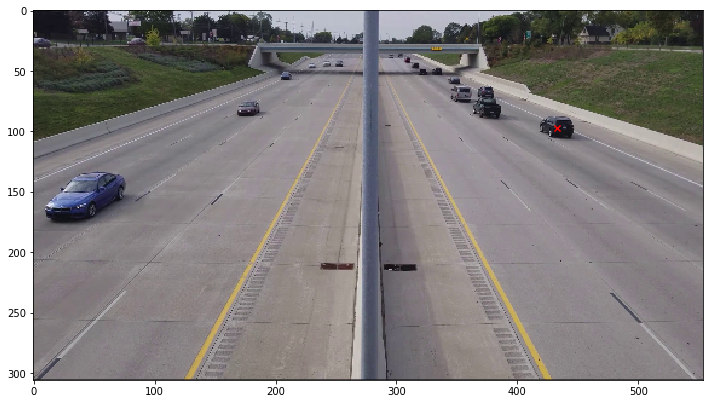

In [ ]:
ii = 321
plt.imshow(imgs[pos[ii, 2]])
plt.scatter(pos[ii, 1], pos[ii,0], c = 'r', marker='x')

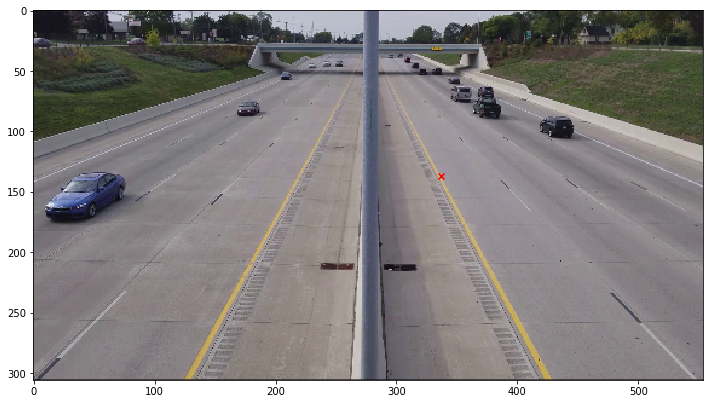

In [ ]:
ii = 321
plt.imshow(imgs[neg[ii, 2]])
plt.scatter(neg[ii, 1], neg[ii,0], c = 'r', marker='x')

In [ ]:
wid = 5

stmp_pos = []
for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]

  if (trow > wid) & (trow < imgs.shape[1] - wid) & (tcol > wid) & (tcol < imgs.shape[2] - wid):
    stmp_pos.append(imgs[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_pos = np.array(stmp_pos)


stmp_neg = []
for ii in range(neg.shape[0]):
  trow, tcol, tind = neg[ii]

  if (trow > wid) & (trow < imgs.shape[1] - wid) & (tcol > wid) & (tcol < imgs.shape[2] - wid):
    stmp_neg.append(imgs[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_neg = np.array(stmp_neg)

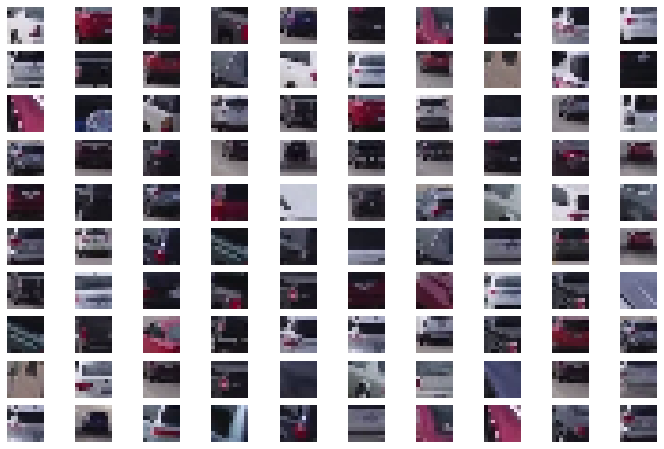

In [ ]:
fig, ax = plt.subplots(10, 10)
for ii in range(100):
  ax[ii // 10, ii % 10].imshow(stmp_pos[np.random.randint(0, high=500)])
  ax[ii // 10, ii % 10].axis("off")
fig.show()

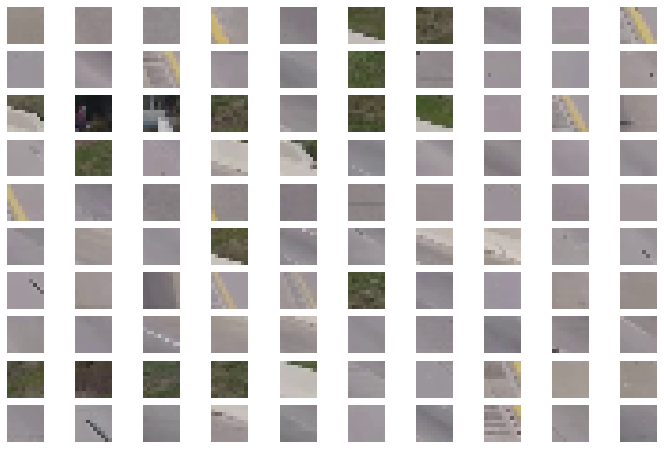

In [ ]:
fig, ax = plt.subplots(10, 10)
for ii in range(100):
  ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
  ax[ii // 10, ii % 10].axis("off")
fig.show()

In [ ]:
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)
targ = np.concatenate((np.full(stmp_neg.shape[0], 0), np.full(stmp_pos.shape[0], 1)))

feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ)

Epoch 1/50
14/14 [==============================] - 0s 18ms/step - loss: 0.7494 - accuracy: 0.5807 - val_loss: 0.5893 - val_accuracy: 0.9333
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 0.5205 - accuracy: 0.8963 - val_loss: 0.3306 - val_accuracy: 0.9600
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.2706 - accuracy: 0.9526 - val_loss: 0.1683 - val_accuracy: 0.9733
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1780 - accuracy: 0.9763 - val_loss: 0.1165 - val_accuracy: 0.9867
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1577 - accuracy: 0.9793 - val_loss: 0.1262 - val_accuracy: 1.0000
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9793 - val_loss: 0.1388 - val_accuracy: 1.0000
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1465 - accuracy: 0.9778 - val_loss: 0.0903 - val_accuracy: 1.0000
Epoch 8/50
14/14 [=

Text(0.5, 0, 'epoch')

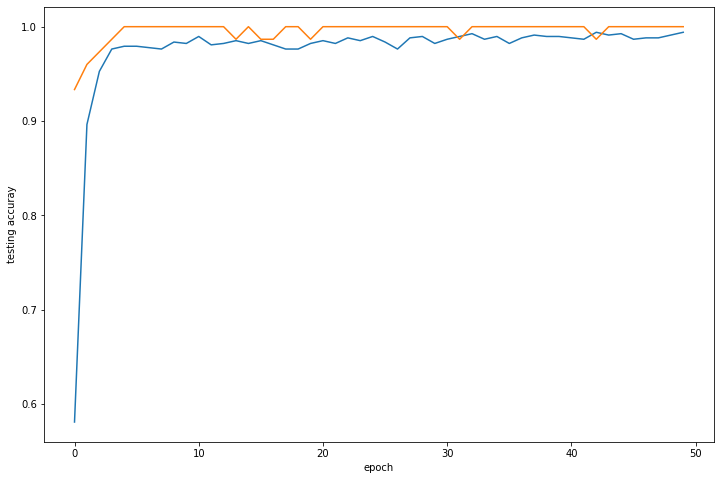

In [ ]:
# -- build a simple CNN
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(2 * wid, 2 * wid, 3), kernel_regularizer=keras.regularizers.l2(0.001))
layer2 = keras.layers.MaxPool2D(2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))
layer4 = keras.layers.MaxPool2D(2)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001))
layer7 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]

# -- instantiate the model
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- fit the model
history = model.fit(feat_tr, targ_tr, epochs=50, validation_split=0.1, batch_size=50)

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

# -- plot the accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("testing accuray")
plt.xlabel("epoch")

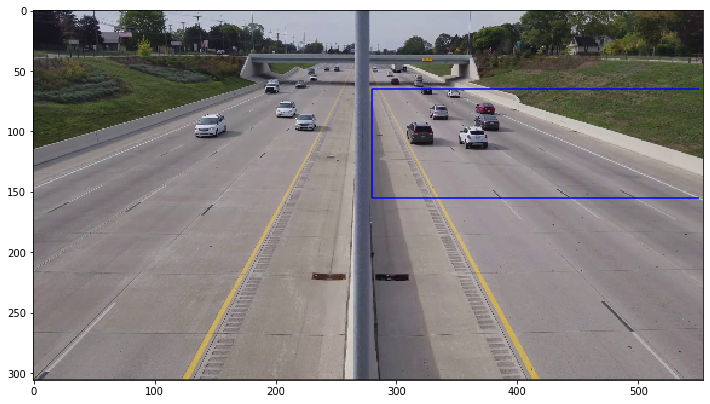

In [ ]:
#Crop the frames as the blue box indicated below, so that the background is simple and 4 lanes have a same length

II = 227

plt.imshow(imgs[II])
plt.vlines(280,65,155, 'b')
plt.hlines(65,280, 550, 'b')
plt.hlines(155,280, 550, 'b')

imgCrop = imgs[:, 65:150, 280:]

In [ ]:
imgCrop.shape

(1360, 85, 274, 3)

In [ ]:
nimg, nrow, ncol, color = imgCrop.shape

pimgs = []

for img in imgCrop:

  stamps = []

  for ii in range(wid, nrow - wid):
    for jj in range(wid, ncol - wid):
      stamps.append(img[ii-wid:ii+wid, jj-wid:jj+wid])
  stamps = np.array(stamps)
      
  pred = model.predict(stamps)
  
  pimg = np.zeros([nrow, ncol])
  pimg[wid:nrow-wid, wid:ncol-wid] = pred[:, 1].reshape(nrow - 2 * wid, ncol - 2 * wid)

  pimgs.append(pimg)

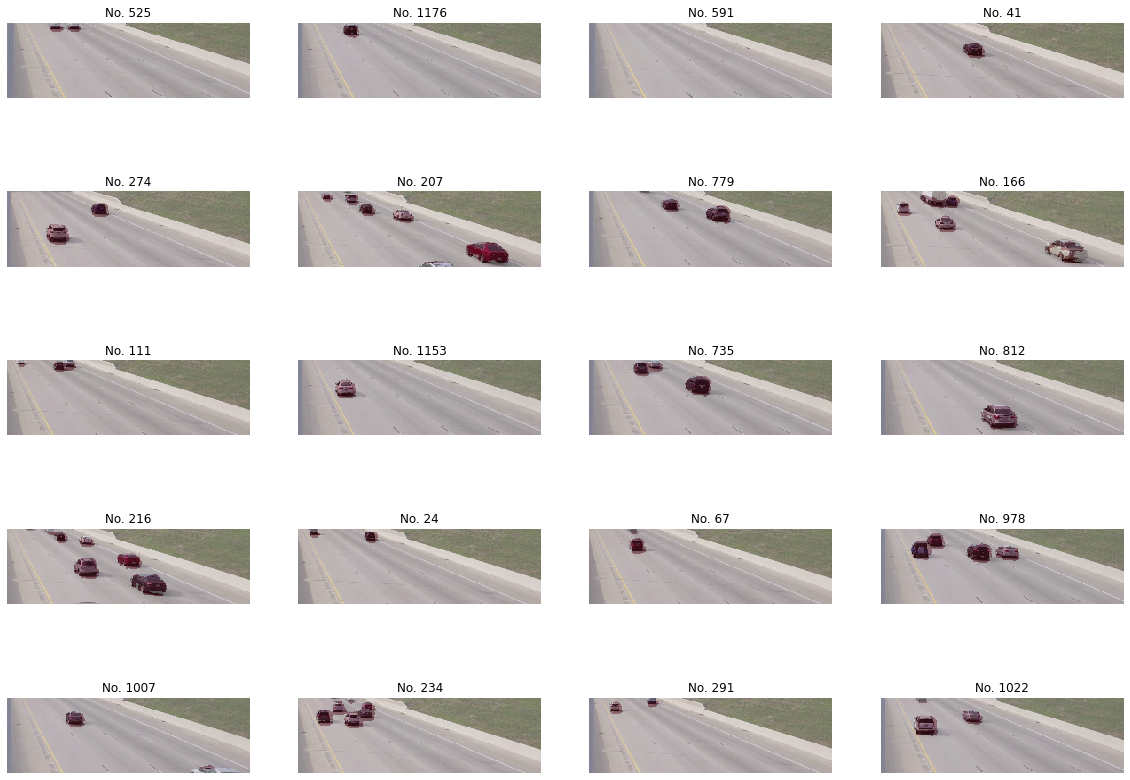

In [ ]:
thr = 0.95
fig, ax = plt.subplots(5, 4, figsize=[20,15])
for ii in range(20):

  jj = np.random.randint(0, nimg)
  ax[ii // 4, ii % 4].imshow(imgCrop[jj])
  ax[ii // 4, ii % 4].imshow(pimgs[jj]>thr, cmap="Reds", alpha=0.3)
  #ax[ii // 4, ii % 4].imshow( binary_opening( pimgs[jj]>thr , iterations=3), cmap="Reds", alpha=0.5)
  ax[ii // 4, ii % 4].set_title('No. {0}'.format(jj))

  #ax[ii // 4, ii % 4].imshow(imgCrop[ii*30])
  #ax[ii // 4, ii % 4].imshow(pimgs[ii*30]>thr, cmap="Reds", alpha=0.3)
  #ax[ii // 4, ii % 4].imshow( binary_opening( pimgs[ii*30]>thr , iterations=3), cmap="Reds", alpha=0.5)

  ax[ii // 4, ii % 4].axis("off")
fig.show()

In [ ]:
#Define bounding boxes according to the dimension of the object.

det_bb = []

for img in pimgs:
  timg = img > thr
  timg = binary_opening(timg, iterations=3)
  labs, nlabs = snm.label(timg)

  if nlabs != 0:

    bb = np.zeros([nlabs, 4])

    for II in range(1, nlabs+1):

      x = np.sum(labs == II, 0)
      x1 = np.where(x!=0)[0].min()
      x2 = np.where(x!=0)[0].max()

      y = np.sum(labs == II, 1)
      y1 = np.where(y!=0)[0].min()
      y2 = np.where(y!=0)[0].max()

      bb[II-1] = np.array([y1, x1, y2, x2])

    tbb = np.concatenate((bb, np.ones([nlabs, 1])), axis=1)
    
    det_bb.append(tbb)



---

---





In [ ]:
!pip install filterpy
!pip install lap

In [ ]:
!git clone https://github.com/gdobler/sort.git

fatal: destination path 'sort' already exists and is not an empty directory.


In [ ]:
cp sort/sort.py .

In [ ]:
from sort import *

---

In [ ]:
mot = Sort()

In [ ]:
tracks = [mot.update(i) for i in det_bb]

In [ ]:
all_ids = []

for track in tracks:
  for obj in track:
    all_ids.append(obj[4])

uids = np.unique(all_ids)

In [ ]:
trackd = {}
for uid in uids:
  trackd[uid] = []

for track in tracks:
  for obj in track:
    trackd[obj[4]].append([ (obj[0] + obj[2])/2 , (obj[1] + obj[3])/2 ])

The number of cars detected is 87


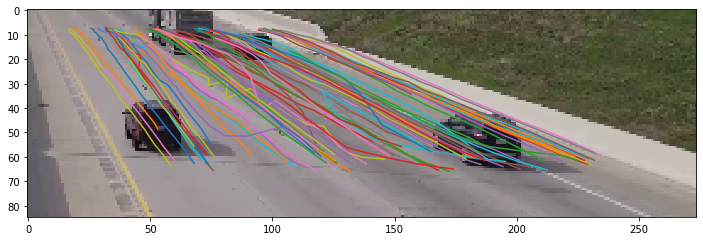

In [ ]:
fig, ax = plt.subplots()

N = 0

nFrames = np.zeros([int(max(uids)), 1])
deltaY = np.zeros([int(max(uids)), 1])

for uid in uids:
  if len(trackd[uid]) > 10:
    pos = np.array(trackd[uid])
    ax.plot(pos[:, 1], pos[:, 0])

    nFrames[int(uid-1)] = len(trackd[uid])
    deltaY[int(uid-1)] = pos[:, 0].max() - pos[:, 0].min() #use the change in y direction to stand for the change in position

    N = N+1    

ax.imshow(imgCrop[0])
fig.show()

print('The number of cars detected is {0}'.format(N))

**By comparing the total number of trajectories to your above estimates for the total number of cars in each lane, comment on the efficacy of your tracker.**

The first estimation is 122, and the tracker got 88. The tracker performs better when the car density is low. It can identify an object is a car or not better. The first method can get multiple peaks from a single car and the cars in neighboring lanes can interfere if that car is tall. But the tracker cannot differentiate overlapping cars, which must be improved before it could be considered useful. Also, the threshold for the pimg varies a lot when the training is different, requiring human judge to make it work. 

**Using your derived trajectories, plot the distribution of vehicle speeds (in pixels per frame).**

In [ ]:
speeds = deltaY[deltaY!=0]/nFrames[nFrames!=0] #deltaY is the change of position and the number of frames is proportional to the time span

Text(0.5, 1.0, 'Speed distribution of the cars.')

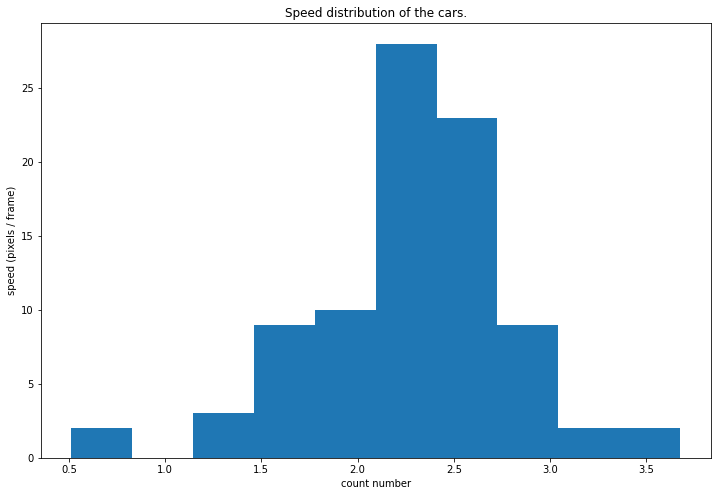

In [ ]:
plt.hist(speeds)
plt.ylabel('speed (pixels / frame)')
plt.xlabel('count number')
plt.title('Speed distribution of the cars.')

**How does the average speed of red vehicles compare with the above distribution?**

In [ ]:
#Creat masks for red objects

masks = np.zeros([nimg, nrow, ncol])

for ii in range(nimg):
  
  imgGau = cv2.GaussianBlur(imgCrop[ii], (15,15), 0)
  mask = np.logical_and(imgGau[ :, :, 0] > 1.1*imgGau[ :, :, 1] , imgGau[ :, :, 0] > 1.1*imgGau[ :, :, 2])

  a, b = snm.label(mask)
  area = snm.sum(mask, a, range(1, b+1))
  
  index = np.where(area<30)[0] #Get rid of tail lights
  
  for jj in index:
    a[a == jj+1] = 0
   
  masks[ii] = a>0


In [ ]:
#Pick out red cars and define bounding boxes

det_bb = []

for ii in range(nimg):
 
  timgRed = np.logical_and(pimgs[ii]>thr, masks[ii])
  labs, nlabs = snm.label(timgRed)

  if nlabs != 0:

    bb = np.zeros([nlabs, 4])

    for jj in range(1, nlabs+1):

      x = np.sum(labs == jj, 0)
      x1 = np.where(x!=0)[0].min()
      x2 = np.where(x!=0)[0].max()

      y = np.sum(labs == jj, 1)
      y1 = np.where(y!=0)[0].min()
      y2 = np.where(y!=0)[0].max()

      bb[jj-1] = np.array([y1, x1, y2, x2])

    tbb = np.concatenate((bb, np.ones([nlabs, 1])), axis=1)
    
    det_bb.append(tbb)

In [ ]:
mot = Sort()

In [ ]:
tracks = [mot.update(i) for i in det_bb]

/content/sort.py:87: RuntimeWarning: invalid value encountered in true_divide
  h = x[2] / w
/content/sort.py:77: RuntimeWarning: invalid value encountered in double_scalars
  r = w / float(h)
/content/sort.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  r = w / float(h)
/content/sort.py:86: RuntimeWarning: invalid value encountered in multiply
  w = np.sqrt(x[2] * x[3])


In [ ]:
all_ids = []

for track in tracks:
  for obj in track:
    all_ids.append(obj[4])

uids = np.unique(all_ids)

In [ ]:
trackd = {}
for uid in uids:
  trackd[uid] = []

for track in tracks:
  for obj in track:
    trackd[obj[4]].append([ (obj[0] + obj[2])/2 , (obj[1] + obj[3])/2 ])

The number of red cars detected is 9


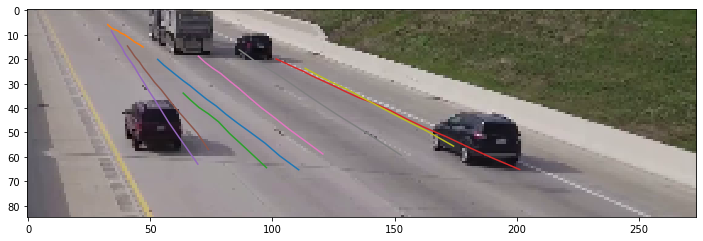

In [ ]:
fig, ax = plt.subplots()

N = 0

nFramesRed = np.zeros([int(max(uids)), 1])
deltaYRed = np.zeros([int(max(uids)), 1])

for uid in uids:
  if len(trackd[uid]) > 8:
    pos = np.array(trackd[uid])
    ax.plot(pos[:, 1], pos[:, 0])

    nFramesRed[int(uid-1)] = len(trackd[uid])
    deltaYRed[int(uid-1)] = pos[:, 0].max() - pos[:, 0].min() #use the change in y direction to stand for the change in position

    N = N+1 

ax.imshow(imgCrop[0])
fig.show()

print('The number of red cars detected is {0}'.format(N))

In [ ]:
speedsRed = deltaYRed[deltaYRed!=0]/nFramesRed[nFramesRed!=0]

The averager speed of the red cars is 2.9367115703234794 pixels / frame


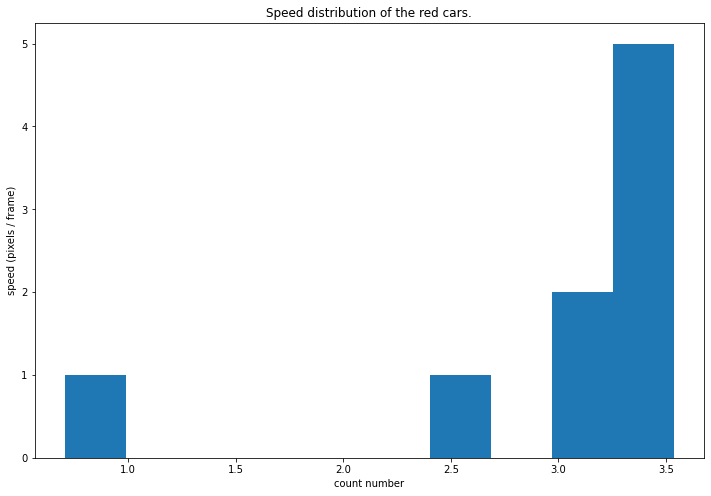

In [ ]:
plt.hist(speedsRed)
plt.ylabel('speed (pixels / frame)')
plt.xlabel('count number')
plt.title('Speed distribution of the red cars.')

print('The averager speed of the red cars is {0} pixels / frame'.format(speedsRed.mean()))

* The one slower than 1 pixel / frame is probably an error, exclude that one and try again.

The averager speed of the red cars is 3.215484959605857 pixels / frame


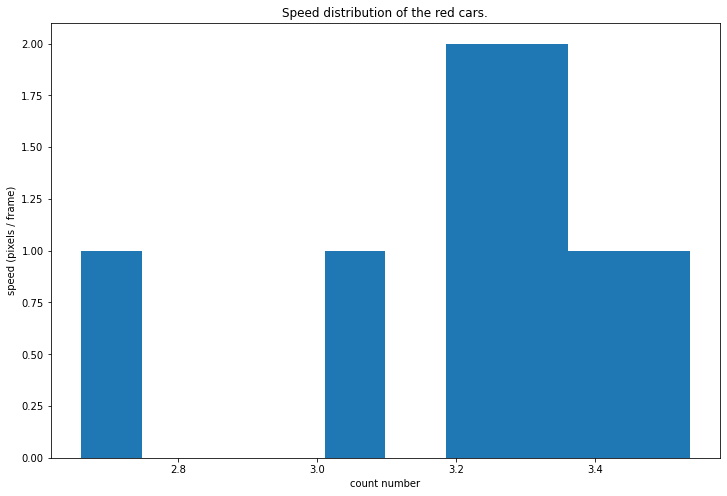

In [ ]:
plt.hist(speedsRed[speedsRed>1])
plt.ylabel('speed (pixels / frame)')
plt.xlabel('count number')
plt.title('Speed distribution of the red cars.')

print('The averager speed of the red cars is {0} pixels / frame'.format(speedsRed[speedsRed>1].mean()))

* In both cases, the average speeds of the red cars are around 3 pixel / frame, which is faster than most cars.

<b>

Consider the following scenario:

*Several years from now, you decide to transition from your field of study (physics, geology, etc.) into a position as a data analyst at a local department of transportation.  You design a vehicle tracker much like you have here to great success in assessing traffic safety by using trajectories to understand how vehicles respond to various road and weather conditions.  Then a pandemic hits, and the local department of health, in an attempt to control the spread of the disease, has partnered with your group to help understand mobility patterns that might lead to disease spread.  To that end, your supervisor requests that you build a "mask" detector using higher resolution traffic cameras near UD's campus that detects pedestrians in an image and determines the probability that they are wearing a facemask.  They explain to you that these detections will be sent to public safety in real time so that they can approach individuals not wearing a mask to request that they do so.  They further explain that this is critical in helping assure mask compliance on UD's campus to stop disease spread so that businesses can reopen safely.*

Briefly (~200 words) describe any ethical issues that you feel might be associated with this project.


</b>

> This can be a great threat to the privacy of people. The videos captured by the detectors can be used for other unknown purposes, and it will be stored somewhere if it is not deleted. And this kind of system will probably continue working even after the pandemic and recording the activities of the people. 

> In fact, what is described here is not fictional, it is what is happening in China. It said that there are almost 1 billion monitoring cameras installed in public areas. The government says these are for safety purposes which is beneficial to better management and can help to fight the criminals. These cameras indeed make it easier to find criminals, but they are also used to monitor the life of normal people. The situation is terrible in Xinjiang Province, where the Uyghurs mainly live in. People are monitored everywhere and is said that the cell phones from Huawei are collecting users' faces anonymously, and it will trigger an "Uyghurs alarm" if the system detects the user is an Uyghur.